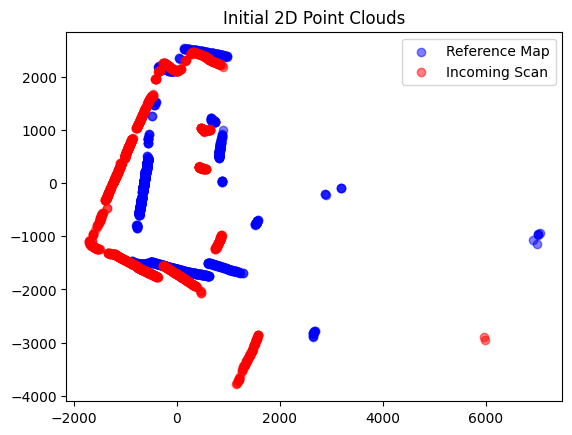

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

test_number = 4

points_path = {
    'base': f'data/test{test_number}a.csv',
    'transformed': f'data/test{test_number}b.csv'
}

pcd_ref = np.loadtxt(points_path['base'], delimiter=',', skiprows=1)
pcd_scan = np.loadtxt(points_path['transformed'], delimiter=',', skiprows=1)
# pcd_scan = pcd_ref @ np.array([[np.cos(0.1), -np.sin(0.1)], [np.sin(0.1), np.cos(0.1)]]) + np.array([1.0, -0.5])

# Plot initial point clouds
plt.scatter(pcd_ref[:, 0], pcd_ref[:, 1], c="blue", label="Reference Map", alpha=0.5)
plt.scatter(pcd_scan[:, 0], pcd_scan[:, 1], c="red", label="Incoming Scan", alpha=0.5)
plt.legend()
plt.title("Initial 2D Point Clouds")
plt.show()

{(14028, -1914): (array([7014., -957.]), array([[0., 0.],
       [0., 0.]])), (1776, 56): (array([888.,  28.]), array([[0., 0.],
       [0., 0.]])), (1642, 960): (array([821., 480.]), array([[0., 0.],
       [0., 0.]])), (1636, 1014): (array([818., 507.]), array([[0., 0.],
       [0., 0.]])), (1646, 1072): (array([823., 536.]), array([[0., 0.],
       [0., 0.]])), (1658, 1132): (array([829., 566.]), array([[0., 0.],
       [0., 0.]])), (1664, 1200): (array([832., 600.]), array([[0., 0.],
       [0., 0.]])), (1674, 1268): (array([837., 634.]), array([[0., 0.],
       [0., 0.]])), (1686, 1338): (array([843., 669.]), array([[0., 0.],
       [0., 0.]])), (1698, 1410): (array([849., 705.]), array([[0., 0.],
       [0., 0.]])), (1704, 1488): (array([852., 744.]), array([[0., 0.],
       [0., 0.]])), (1760, 1764): (array([880., 882.]), array([[0., 0.],
       [0., 0.]])), (1474, 2292): (array([ 737., 1146.]), array([[0., 0.],
       [0., 0.]])), (1422, 2332): (array([ 711., 1166.]), array([[0

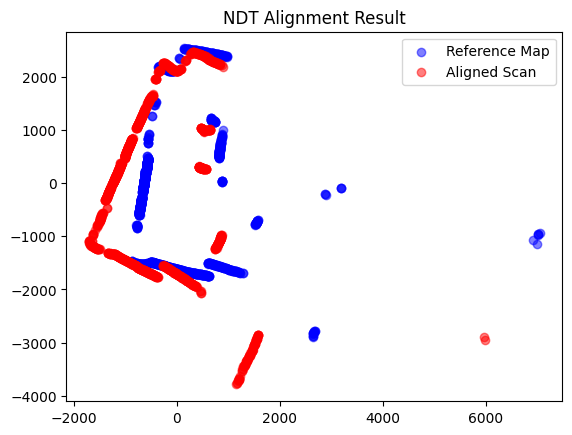

0.0 0.0 0.0


In [ ]:
from scipy.optimize import minimize

# Create a grid for NDT
def compute_ndt_grid(points, grid_size=0.5):
    """ Compute Gaussian distributions per grid cell. """
    grid = {}
    for p in points:
        key = (int(p[0] / grid_size), int(p[1] / grid_size))
        if key not in grid:
            grid[key] = []
        grid[key].append(p)

    gaussians = {}
    for key, pts in grid.items():
        pts = np.array(pts)
        mean = np.mean(pts, axis=0)
        print(mean, pts)
        cov = np.cov(pts.T) if len(pts) > 1 else np.eye(2) * 0.01  # Avoid singular matrices
        gaussians[key] = (mean, cov)

    print(gaussians)
    return gaussians

# Match point clouds by optimizing transformation
def match_ndt(scan, ref_ndt, grid_size=0.5):
    """ Optimize transformation parameters (rotation + translation). """
    
    def objective(params):
        """ Cost function: Compute alignment error between transformed scan and reference NDT grid. """
        theta, tx, ty = params
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_scan = scan @ rot_matrix.T + np.array([tx, ty])
        
        cost = 0
        for p in transformed_scan:
            key = (int(p[0] / grid_size), int(p[1] / grid_size))
            if key in ref_ndt:
                mean, cov = ref_ndt[key]
                diff = p - mean
                cost += diff @ np.linalg.pinv(cov) @ diff.T  # Mahalanobis distance
        return cost

    # Optimize rotation (θ) and translation (tx, ty)
    result = minimize(objective, [0, 0, 0], method="Powell")
    return result.x  # Returns (theta, tx, ty)

# Compute NDT for the reference map
ndt_ref = compute_ndt_grid(pcd_ref, grid_size=0.5)

# Find the best transformation
theta_opt, tx_opt, ty_opt = match_ndt(pcd_scan, ndt_ref)

# Apply the optimized transformation
rot_matrix = np.array([[np.cos(theta_opt), -np.sin(theta_opt)], [np.sin(theta_opt), np.cos(theta_opt)]])
pcd_scan_aligned = pcd_scan @ rot_matrix.T + np.array([tx_opt, ty_opt])

# Plot the final alignment
plt.scatter(pcd_ref[:, 0], pcd_ref[:, 1], c="blue", label="Reference Map", alpha=0.5)
plt.scatter(pcd_scan_aligned[:, 0], pcd_scan_aligned[:, 1], c="red", label="Aligned Scan", alpha=0.5)
plt.legend()
plt.title("NDT Alignment Result")
plt.show()

print(theta_opt, tx_opt, ty_opt)

